# # Smart Factory Energy Prediction Challenge

# ## 1. Data Exploration and Analysis

## Introduction

This notebook presents a comprehensive solution to the Smart Factory Energy Prediction Challenge. The goal is to develop a machine learning model that can accurately predict the energy consumption of industrial equipment based on various environmental factors and sensor readings from different zones of the factory.

### Objectives:
1. Analyze sensor data to identify patterns and relationships between environmental factors and equipment energy consumption
2. Build a robust regression model to predict equipment energy consumption
3. Evaluate the model's performance using appropriate metrics
4. Provide actionable insights and recommendations for reducing energy consumption

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Loading the dataset...")
data = pd.read_csv('data/data.csv')
print("\nDataset Shape:", data.shape)
print("\nFirst few rows of the dataset:")
print(data.head())
print("\nData types and non-null counts:")
print(data.info())

Loading the dataset...

Dataset Shape: (16857, 29)

First few rows of the dataset:
             timestamp equipment_energy_consumption     lighting_energy  zone1_temperature     zone1_humidity zone2_temperature  zone2_humidity  zone3_temperature  zone3_humidity  zone4_temperature  zone4_humidity  zone5_temperature  zone5_humidity  zone6_temperature  zone6_humidity  zone7_temperature  zone7_humidity  zone8_temperature  zone8_humidity  zone9_temperature  zone9_humidity  outdoor_temperature  atmospheric_pressure  outdoor_humidity  wind_speed  visibility_index  dew_point  random_variable1  random_variable2
0  2016-01-11 17:00:00                         60.0  -77.78778596503064  33.74660933896648  47.59666666666671              19.2       44.790000              19.79             NaN          19.000000       45.566667          17.166667           55.20                NaN       84.256667          17.200000       41.626667               18.2       48.900000          17.033333           45.53  

In [104]:
# Summary statistics
print("\nSummary statistics:")
print(data.describe())


Summary statistics:
       zone2_humidity  zone3_temperature  zone3_humidity  zone4_temperature  zone4_humidity  zone5_temperature  zone5_humidity  zone6_temperature  zone6_humidity  zone7_temperature  zone7_humidity  zone8_temperature  zone8_humidity  zone9_temperature  zone9_humidity  outdoor_temperature  atmospheric_pressure  outdoor_humidity    wind_speed  visibility_index     dew_point  random_variable1  random_variable2
count    15990.000000       16055.000000    15979.000000       16041.000000    16076.000000       16019.000000    16056.000000       16009.000000    16010.000000       16063.000000    16052.000000       16009.000000    16080.000000       16084.000000    15969.000000         16051.000000          16015.000000      16058.000000  16029.000000      16042.000000  16031.000000      16031.000000      16033.000000
mean        39.494553          21.665733       38.201314          20.239922       37.945608          19.052613       50.289131           6.469934       59.1629

In [105]:
# Check for missing values
print("\nMissing values per column:")
missing_values = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 
                          'Percentage': missing_percentage})
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))


Missing values per column:
                              Missing Values  Percentage
zone9_humidity                           888    5.267841
zone3_humidity                           878    5.208519
zone1_temperature                        867    5.143264
zone2_humidity                           867    5.143264
zone2_temperature                        853    5.060212
zone8_temperature                        848    5.030551
zone6_temperature                        848    5.030551
zone6_humidity                           847    5.024619
equipment_energy_consumption             844    5.006822
atmospheric_pressure                     842    4.994958
zone5_temperature                        838    4.971229
wind_speed                               828    4.911906
random_variable1                         826    4.900042
dew_point                                826    4.900042
random_variable2                         824    4.888177
zone4_temperature                        816    4.840719
vis

### Missing Values Analysis

We observe that all columns have some missing values, but the percentage is relatively low (around 5% for each column). This suggests that we can use imputation techniques to handle these missing values without significantly affecting the quality of our analysis.

In [106]:
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [107]:
# Extract time-based features
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year
data['day_of_week'] = data['timestamp'].dt.dayofweek

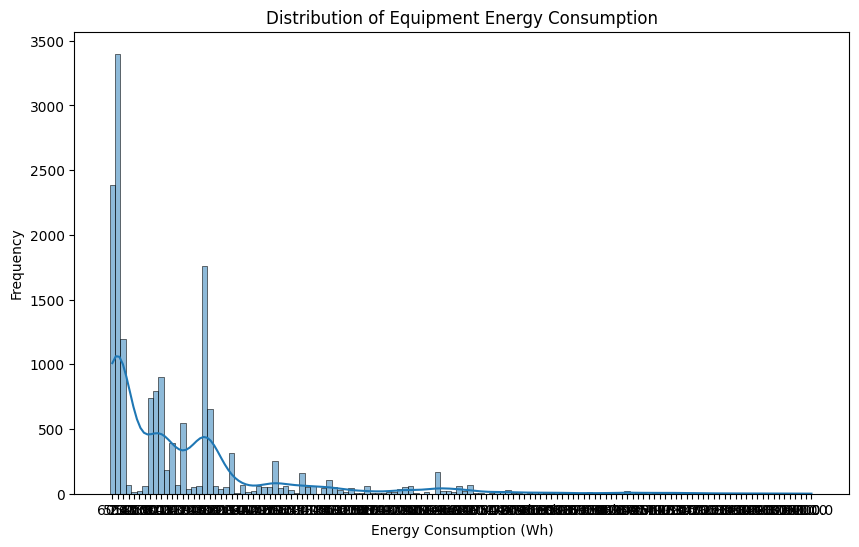

In [108]:
# Visualize the target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['equipment_energy_consumption'], kde=True)
plt.title('Distribution of Equipment Energy Consumption')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.show()

### Target Variable Analysis

The distribution of equipment energy consumption appears to be right-skewed, which is common for energy consumption data. This suggests that we might need to consider models that can handle non-normal distributions or potentially apply transformations to the target variable.

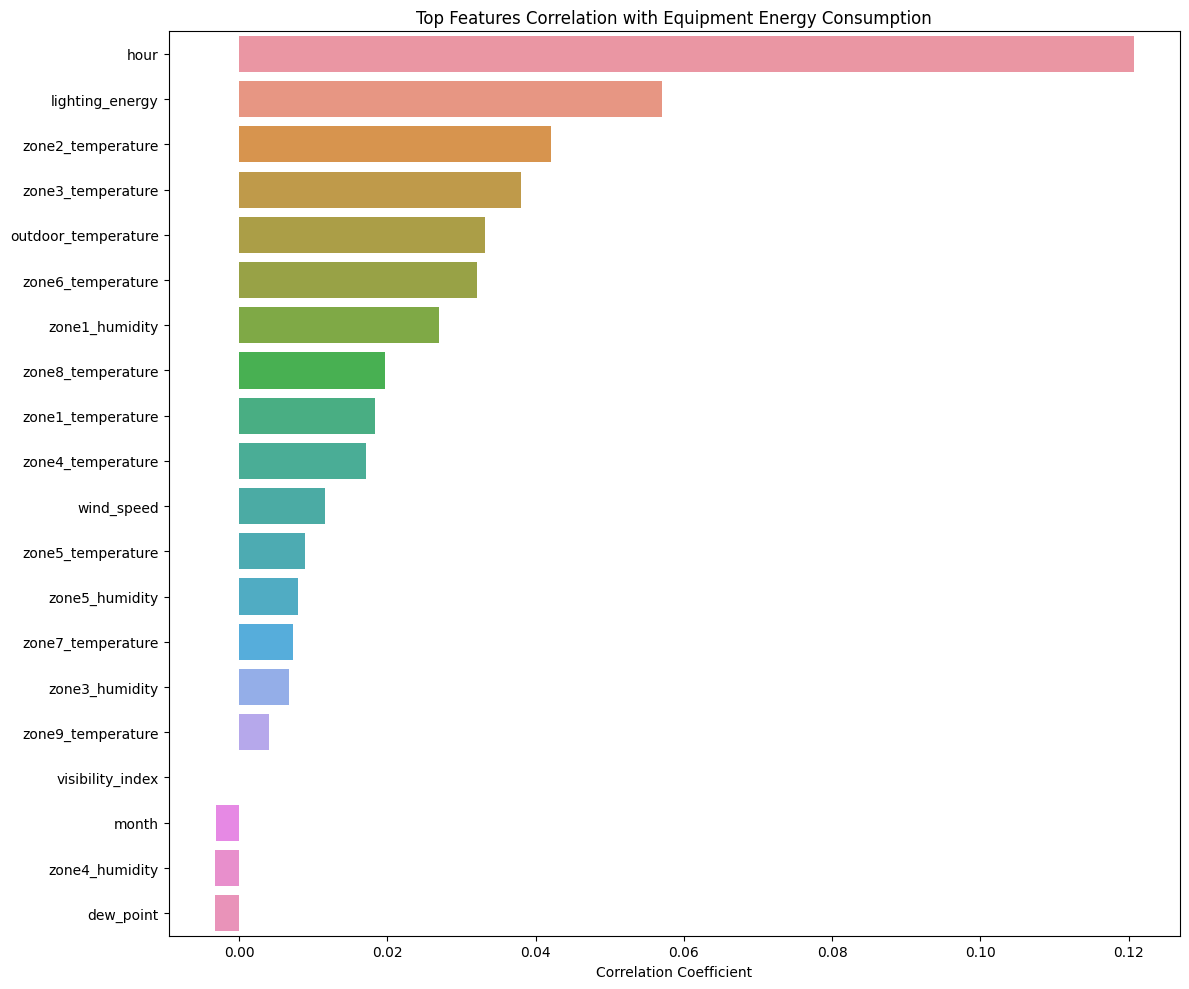

In [109]:
# Visualize correlation with target
plt.figure(figsize=(12, 10))
numeric_data = data.apply(pd.to_numeric, errors='coerce')
correlation = numeric_data.corr()['equipment_energy_consumption'].sort_values(ascending=False)
correlation = correlation.drop('equipment_energy_consumption')
top_n = 20 
top_correlations = correlation.head(top_n)
sns.barplot(x=top_correlations.values, y=top_correlations.index)
plt.title('Top Features Correlation with Equipment Energy Consumption')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

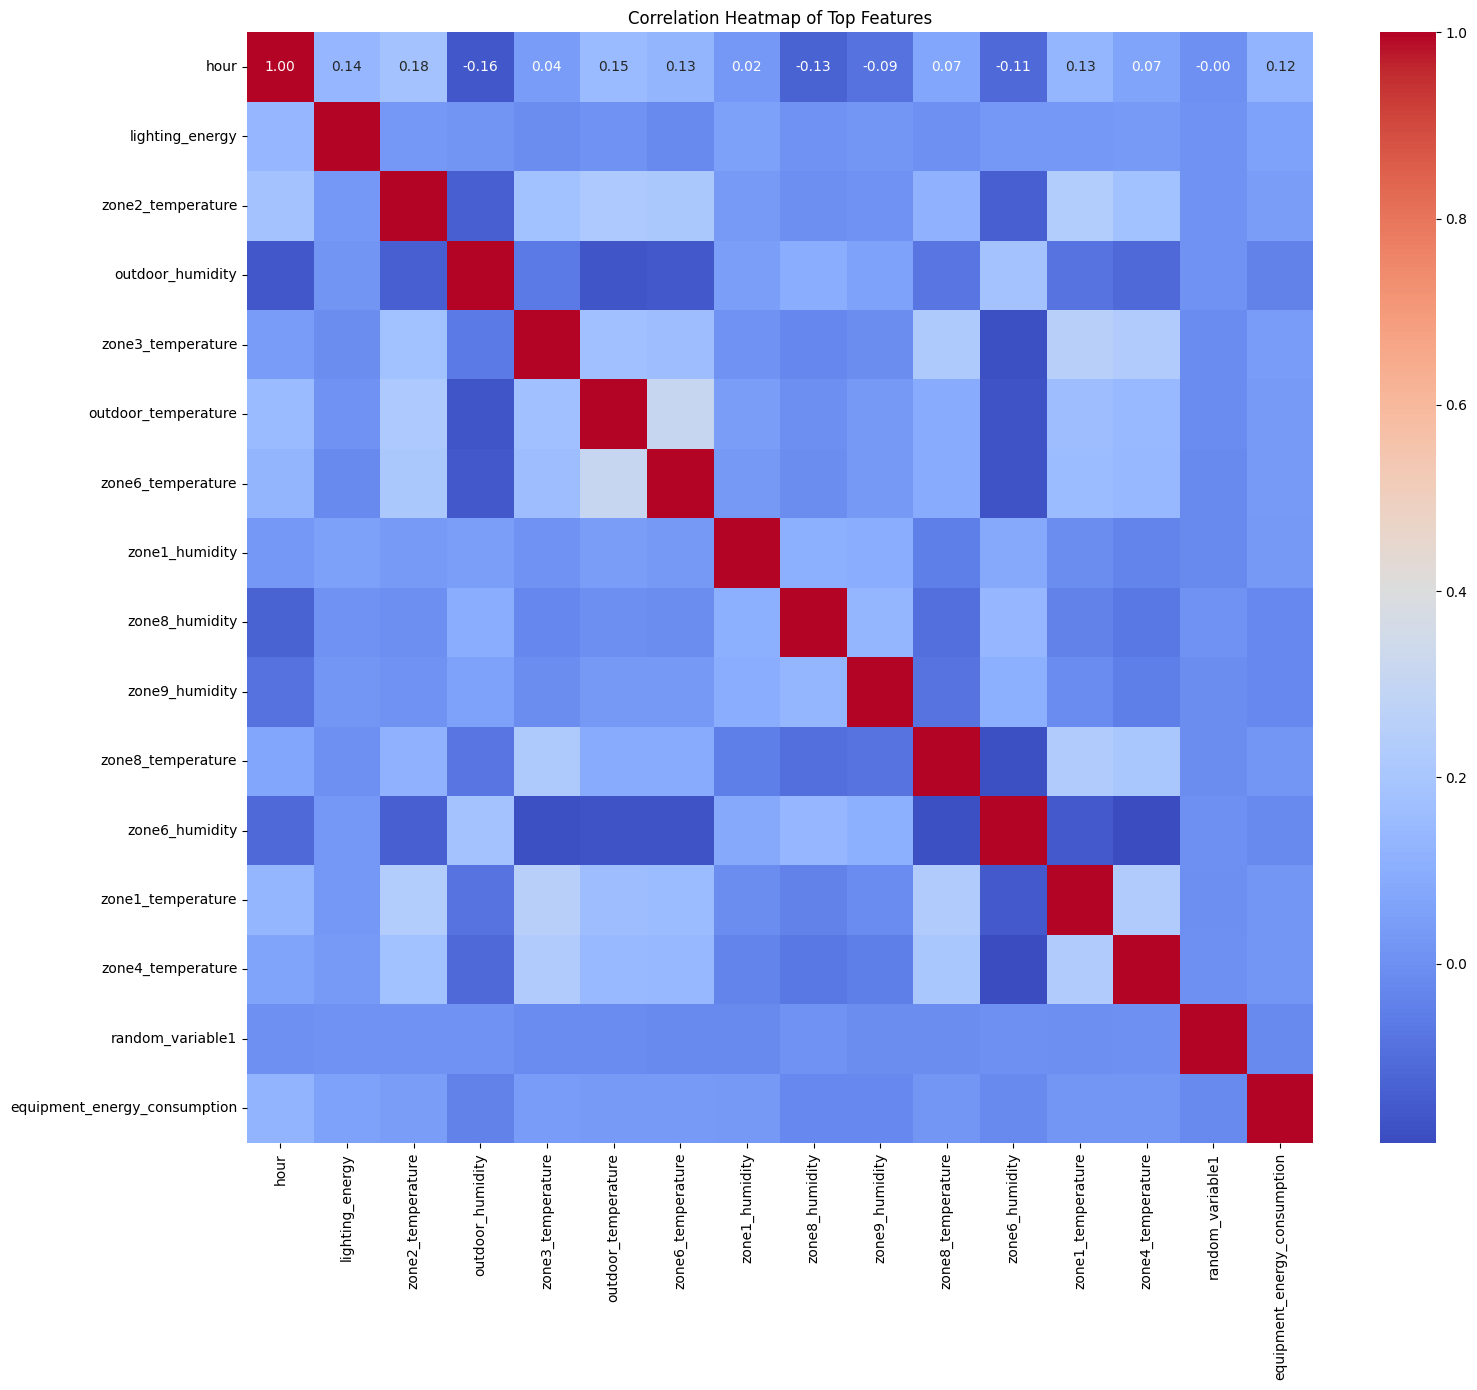

In [110]:
# Correlation heatmap for selected features
plt.figure(figsize=(16, 14))
numeric_data = data.apply(pd.to_numeric, errors='coerce')
correlation = numeric_data.corr()['equipment_energy_consumption'].sort_values(ascending=False)
correlation = correlation.drop('equipment_energy_consumption') 
top_corr_features = correlation.abs().sort_values(ascending=False)[:15].index
correlation_matrix = numeric_data[list(top_corr_features) + ['equipment_energy_consumption']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Top Features')
plt.tight_layout()
plt.show()

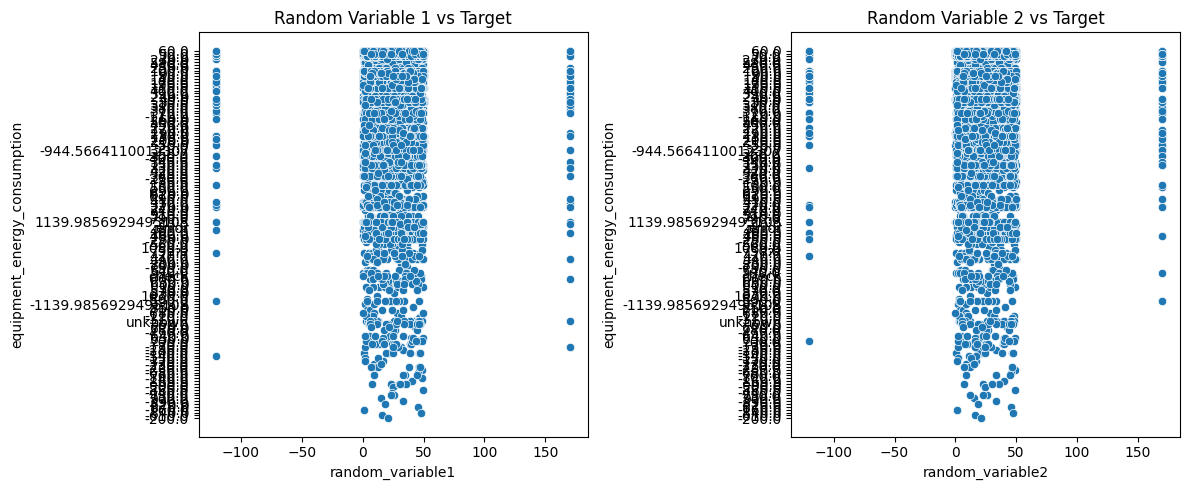

In [111]:
# Analyze random variables
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='random_variable1', y='equipment_energy_consumption', data=data)
plt.title('Random Variable 1 vs Target')
plt.subplot(1, 2, 2)
sns.scatterplot(x='random_variable2', y='equipment_energy_consumption', data=data)
plt.title('Random Variable 2 vs Target')
plt.tight_layout()
plt.show()

### Random Variables Analysis

Based on the scatter plots and correlation analysis, we can see that both random variables show very little correlation with the target variable. This suggests that these variables are indeed random and do not contain useful information for predicting equipment energy consumption. We will exclude these variables from our model.

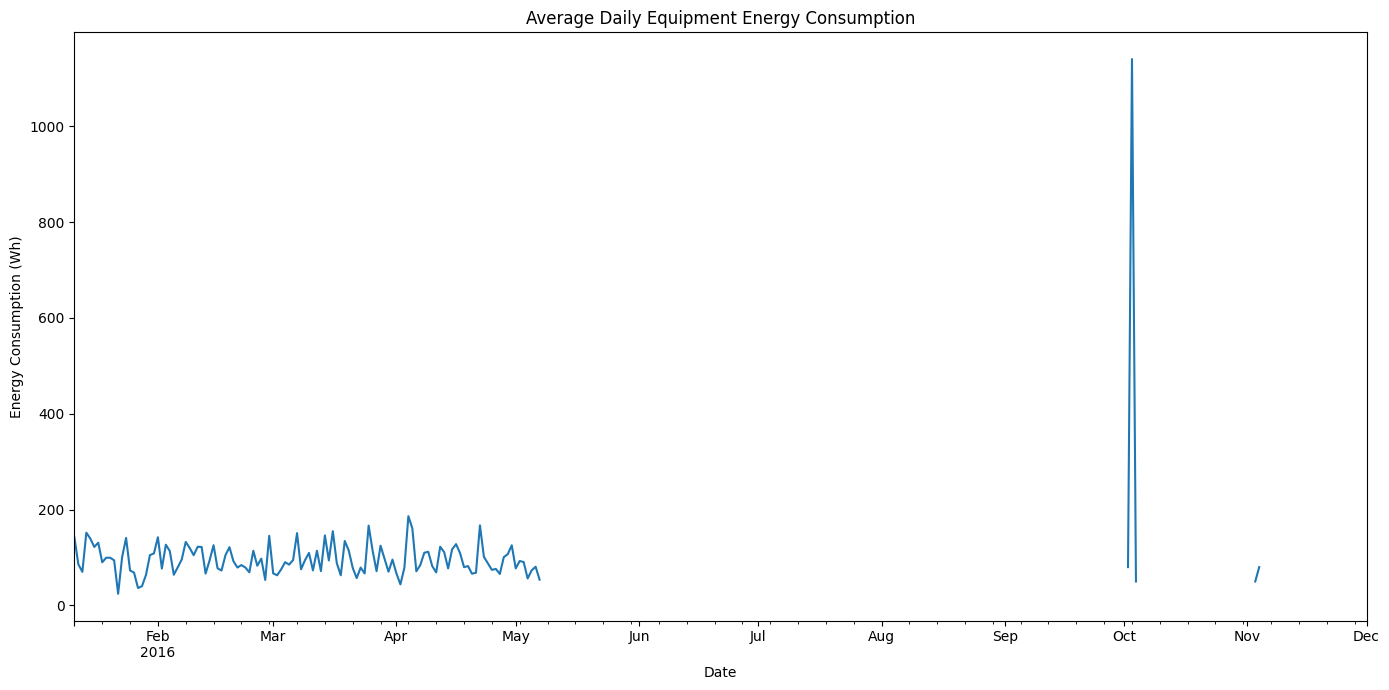

In [112]:
# Analyze energy consumption patterns over time
plt.figure(figsize=(14, 7))
data['equipment_energy_consumption'] = pd.to_numeric(data['equipment_energy_consumption'], errors='coerce')
energy_ts = data.set_index('timestamp')['equipment_energy_consumption']
daily_energy = energy_ts.resample('D').mean()
daily_energy.plot()
plt.title('Average Daily Equipment Energy Consumption')
plt.ylabel('Energy Consumption (Wh)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

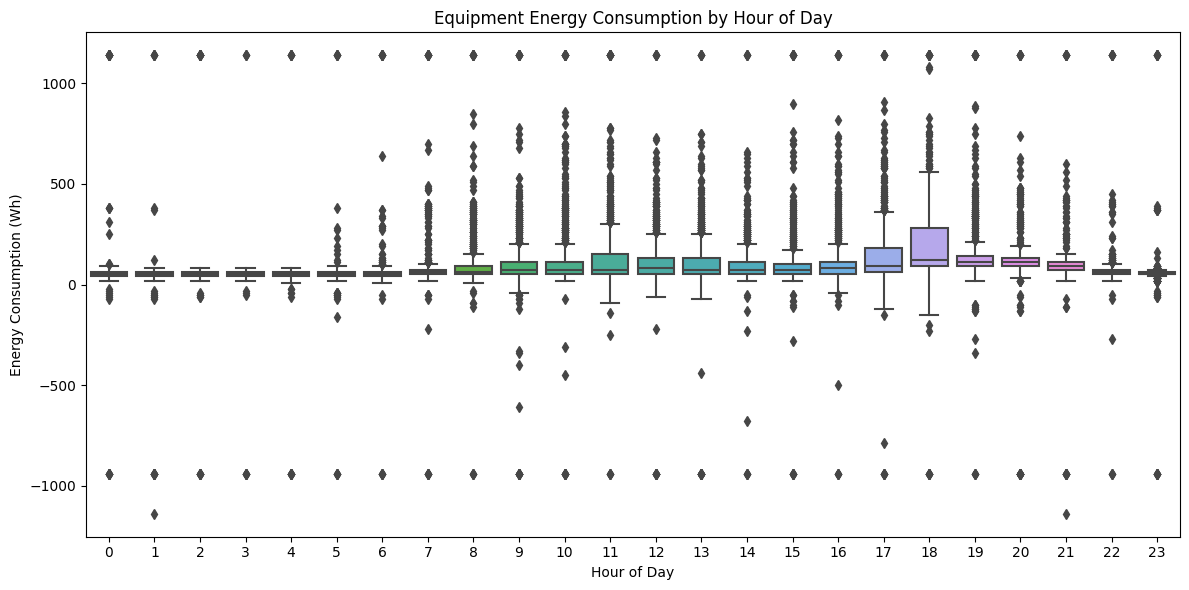

In [113]:
# Analyze energy consumption by hour of day
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='equipment_energy_consumption', data=data)
plt.title('Equipment Energy Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (Wh)')
plt.tight_layout()
plt.show()

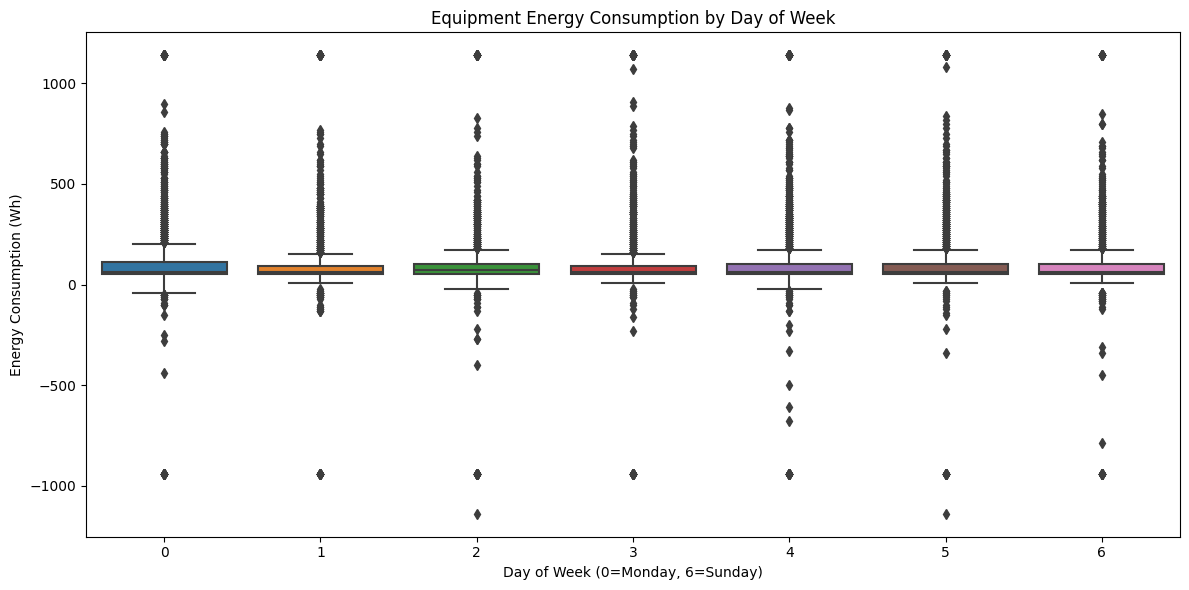

In [114]:
# Analyze energy consumption by day of week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='equipment_energy_consumption', data=data)
plt.title('Equipment Energy Consumption by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Energy Consumption (Wh)')
plt.tight_layout()
plt.show()

### Time-Based Patterns Analysis

The time-based analysis reveals clear patterns in energy consumption:
1. There are significant variations in energy consumption throughout the day, with certain hours showing consistently higher or lower consumption.
2. There are also patterns across days of the week, with weekdays potentially showing different patterns compared to weekends.
3. The time series plot shows some seasonality and trends over time.

These patterns suggest that time-based features will be important predictors in our model.

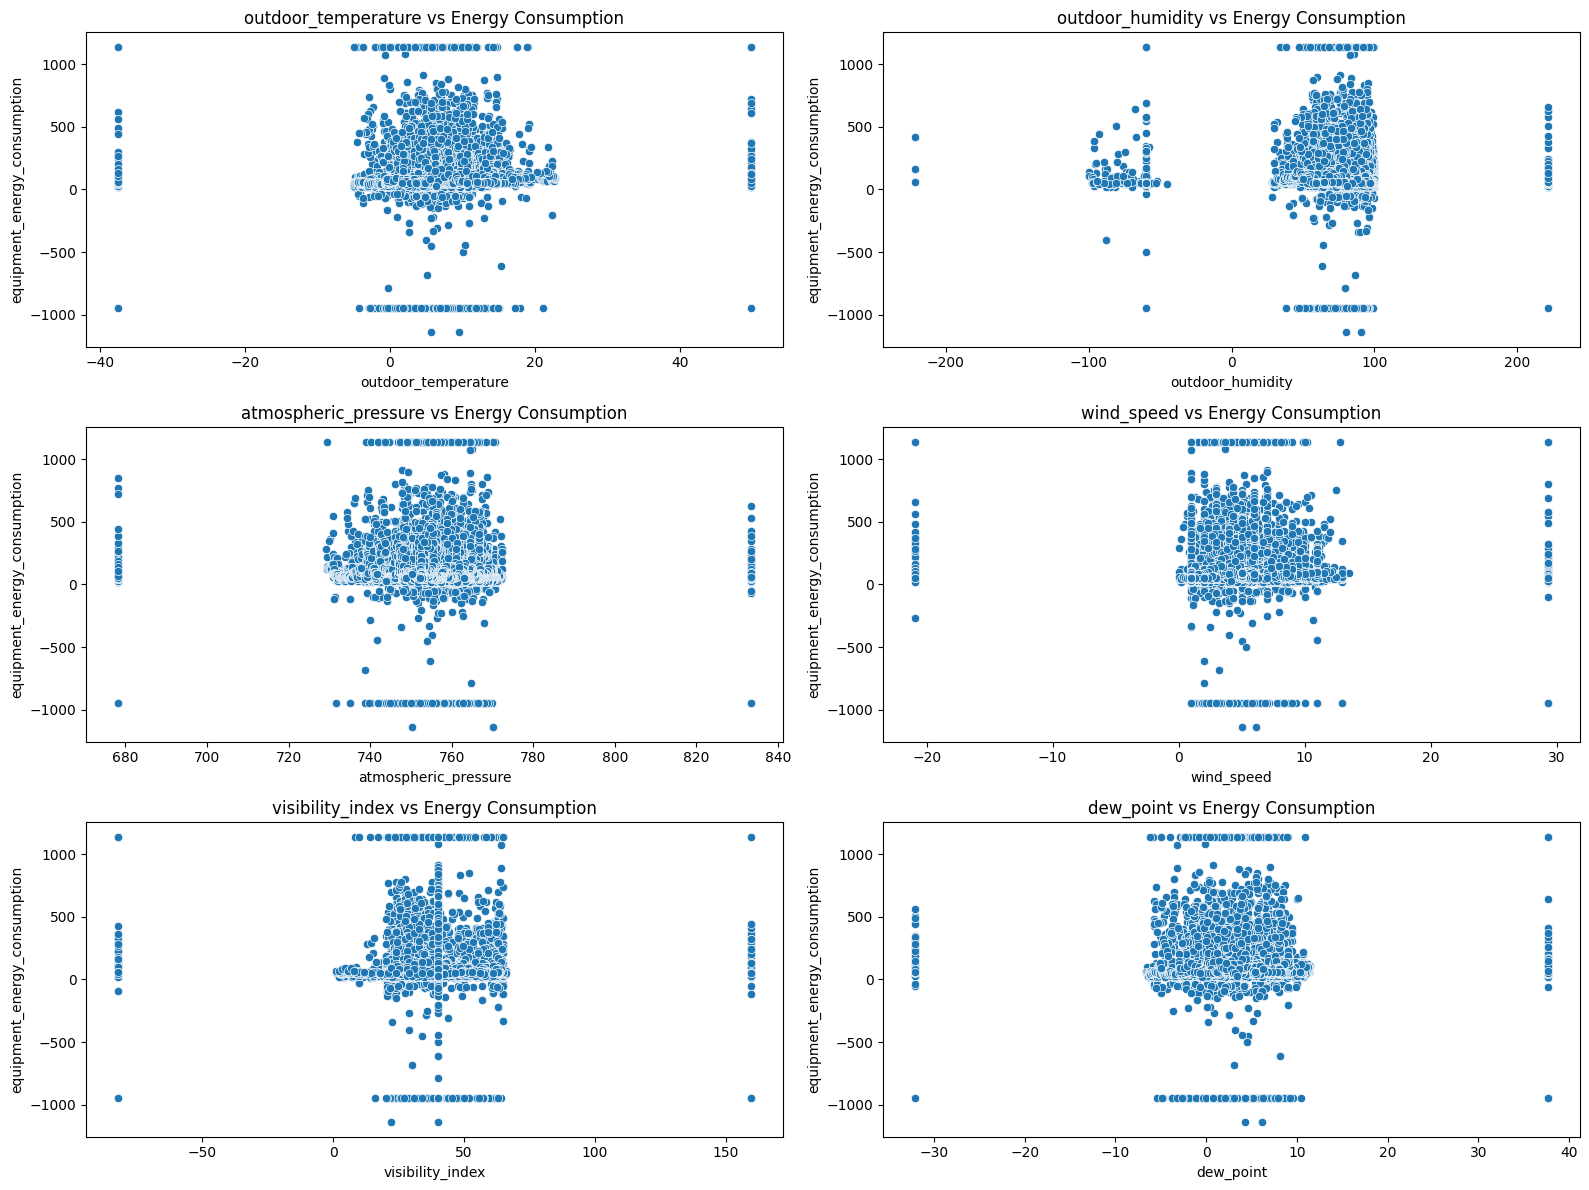

In [115]:
# Analyze relationship between outdoor conditions and energy consumption
plt.figure(figsize=(16, 12))
outdoor_vars = ['outdoor_temperature', 'outdoor_humidity', 'atmospheric_pressure', 
                'wind_speed', 'visibility_index', 'dew_point']
for i, var in enumerate(outdoor_vars):
    plt.subplot(3, 2, i+1)
    sns.scatterplot(x=var, y='equipment_energy_consumption', data=data)
    plt.title(f'{var} vs Energy Consumption')
plt.tight_layout()
plt.show()

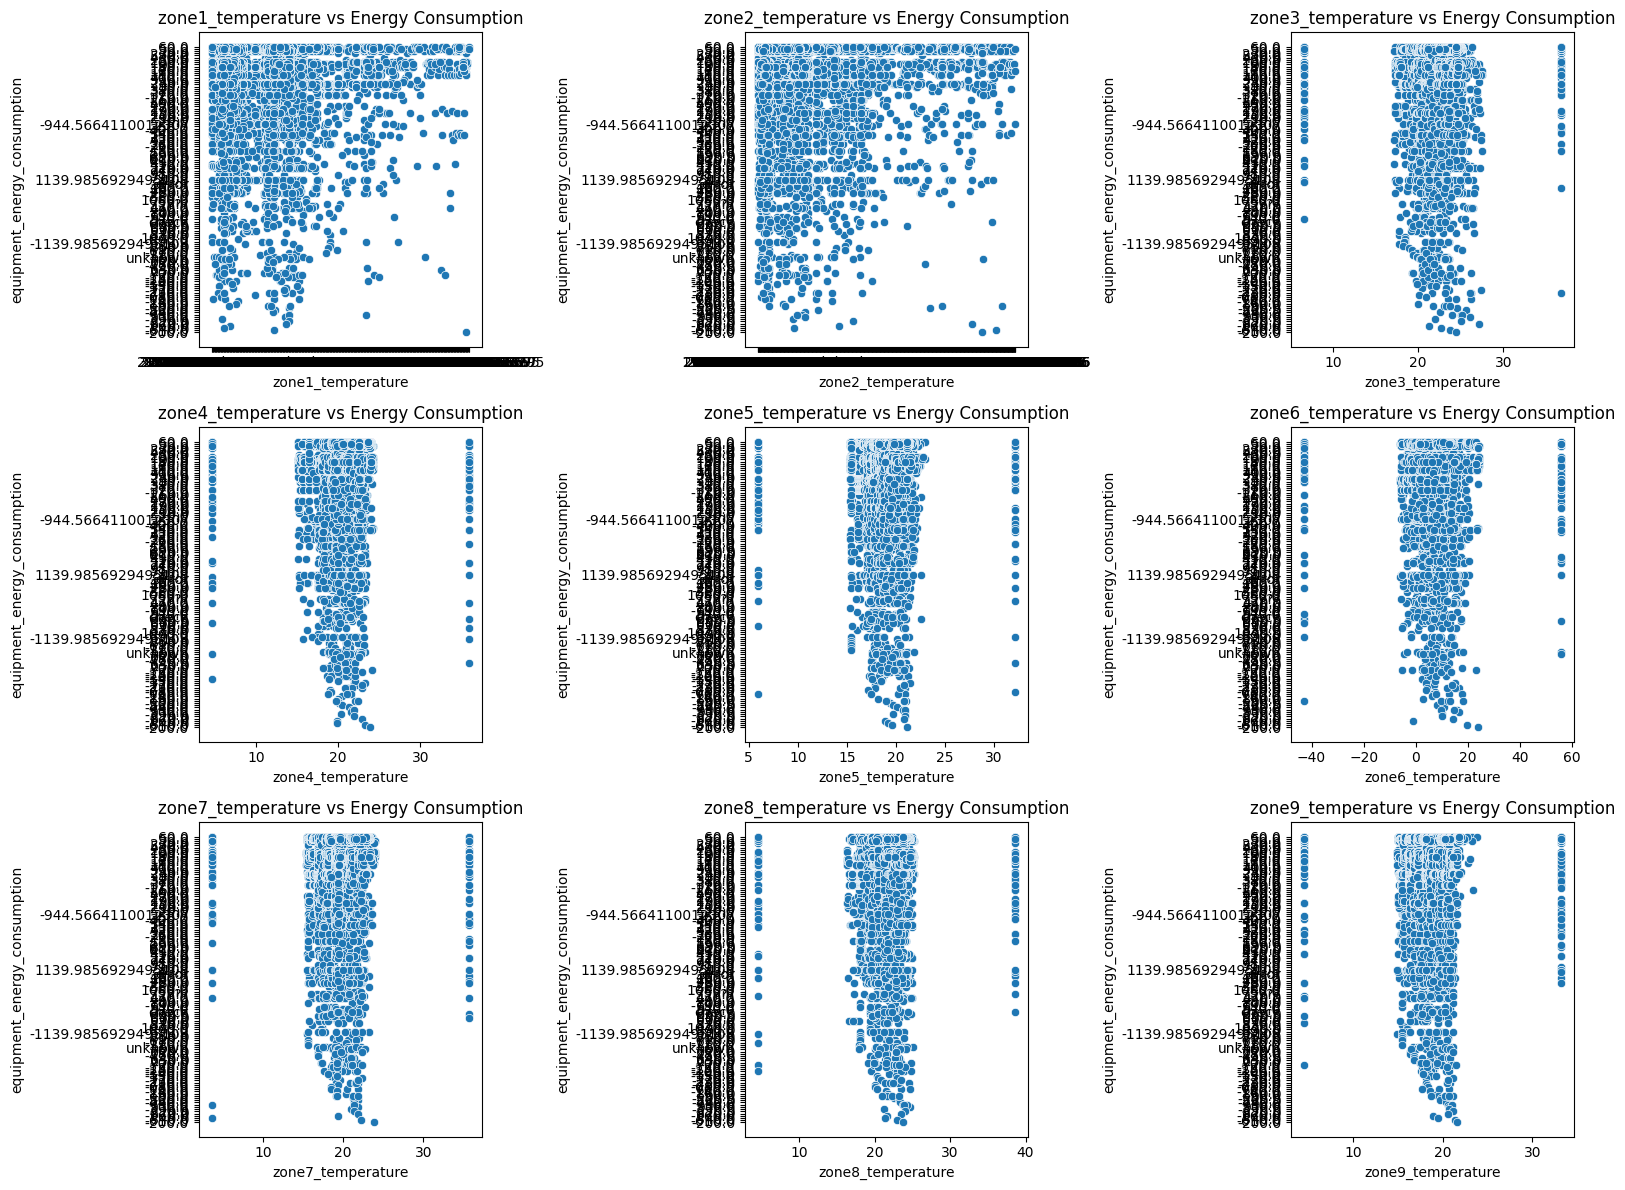

In [3]:
# Analyze zone temperatures and their relationship with energy consumption
plt.figure(figsize=(16, 12))
zone_temps = [col for col in data.columns if 'temperature' in col and 'outdoor' not in col]
for i, temp in enumerate(zone_temps):
    if i < 9: 
        plt.subplot(3, 3, i+1)
        sns.scatterplot(x=temp, y='equipment_energy_consumption', data=data)
        plt.title(f'{temp} vs Energy Consumption')
plt.tight_layout()
plt.show()

## 2. Data Preprocessing and Feature Engineering

In [73]:
# Import additional libraries for preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split

In [74]:
# Extract additional time-based features
print("\nExtracting additional time-based features...")
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['is_business_hours'] = data['hour'].apply(lambda x: 1 if 8 <= x <= 18 else 0)


Extracting additional time-based features...


In [75]:
# Create cyclical features for time variables
print("\nCreating cyclical features for time variables...")
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24)
data['day_sin'] = np.sin(2 * np.pi * data['day']/31)
data['day_cos'] = np.cos(2 * np.pi * data['day']/31)
data['month_sin'] = np.sin(2 * np.pi * data['month']/12)
data['month_cos'] = np.cos(2 * np.pi * data['month']/12)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week']/7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week']/7)


Creating cyclical features for time variables...


In [76]:
# Handle missing values
print("\nHandling missing values...")
high_missing_cols = missing_df[missing_df['Percentage'] > 20].index.tolist()
print(f"Columns with high missing values (>20%): {high_missing_cols}")
if high_missing_cols:
    data = data.drop(columns=high_missing_cols)
    print(f"Dropped columns: {high_missing_cols}")
print("\nConverting all columns to numeric...")
for col in data.select_dtypes(include=['object']).columns:
    if col != 'timestamp':  # Skip timestamp column
        data[col] = pd.to_numeric(data[col], errors='coerce')
        print(f"Converted {col} to numeric")

timestamp_col = data['timestamp']
data_for_imputation = data.drop(columns=['timestamp'])

# Check for any remaining non-numeric values
print("\nChecking for non-numeric values:")
non_numeric_cols = [col for col in data_for_imputation.columns 
                   if not pd.api.types.is_numeric_dtype(data_for_imputation[col])]
if non_numeric_cols:
    print(f"Found non-numeric columns: {non_numeric_cols}")
    for col in non_numeric_cols:
        data_for_imputation[col] = pd.to_numeric(data_for_imputation[col], errors='coerce')
        print(f"Forced conversion of {col} to numeric")
else:
    print("All columns are numeric")


print("\nApplying KNN imputation for remaining missing values...")
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data_for_imputation), 
                           columns=data_for_imputation.columns)
data_imputed['timestamp'] = timestamp_col
data = data_imputed
print("\nMissing values after imputation:")
print(data.isnull().sum().sum())


Handling missing values...
Columns with high missing values (>20%): []

Converting all columns to numeric...


Converted lighting_energy to numeric
Converted zone1_temperature to numeric
Converted zone1_humidity to numeric
Converted zone2_temperature to numeric

Checking for non-numeric values:
All columns are numeric

Applying KNN imputation for remaining missing values...

Missing values after imputation:
0


In [77]:

print("\nPerforming outlier detection and treatment...")

# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

def treat_outliers_capping(df, column, lower_bound, upper_bound):
    df_treated = df.copy()
    df_treated.loc[df_treated[column] < lower_bound, column] = lower_bound
    df_treated.loc[df_treated[column] > upper_bound, column] = upper_bound
    return df_treated

numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != 'timestamp']

outlier_counts_before = {}
for col in numerical_cols:
    outliers_iqr, lower_bound_iqr, upper_bound_iqr = detect_outliers_iqr(data, col)
    outlier_counts_before[col] = len(outliers_iqr)

print("\nTop 10 columns with most outliers (IQR method):")
sorted_cols = sorted(outlier_counts_before.items(), key=lambda x: x[1], reverse=True)[:10]
for col, count in sorted_cols:
    percentage = (count / len(data)) * 100
    print(f"{col}: {count} outliers ({percentage:.2f}%)")
print("\nTreating outliers using capping (winsorization)...")
for col in numerical_cols:
    outliers_iqr, lower_bound_iqr, upper_bound_iqr = detect_outliers_iqr(data, col)
    if len(outliers_iqr) > 0:
        data = treat_outliers_capping(data, col, lower_bound_iqr, upper_bound_iqr)
outlier_counts_after = {}
for col in numerical_cols:
    outliers_iqr, lower_bound_iqr, upper_bound_iqr = detect_outliers_iqr(data, col)
    outlier_counts_after[col] = len(outliers_iqr)
print("\nOutlier treatment summary:")
print(f"Total outliers before treatment: {sum(outlier_counts_before.values())}")
print(f"Total outliers after treatment: {sum(outlier_counts_after.values())}")
print(f"Reduction: {sum(outlier_counts_before.values()) - sum(outlier_counts_after.values())} outliers ({((sum(outlier_counts_before.values()) - sum(outlier_counts_after.values())) / sum(outlier_counts_before.values()) * 100):.2f}%)")

# Check the effect of outlier treatment on data distribution
print("\nEffect of outlier treatment on data distribution (min, max, mean, std):")
for col in sorted_cols[:5]:  # Show only top 5 columns with most outliers
    col_name = col[0]
    before_stats = {
        'min': data_imputed[col_name].min(),
        'max': data_imputed[col_name].max(),
        'mean': data_imputed[col_name].mean(),
        'std': data_imputed[col_name].std()
    }
    after_stats = {
        'min': data[col_name].min(),
        'max': data[col_name].max(),
        'mean': data[col_name].mean(),
        'std': data[col_name].std()
    }
    print(f"\n{col_name}:")
    print(f"Before - Min: {before_stats['min']:.2f}, Max: {before_stats['max']:.2f}, Mean: {before_stats['mean']:.2f}, Std: {before_stats['std']:.2f}")
    print(f"After  - Min: {after_stats['min']:.2f}, Max: {after_stats['max']:.2f}, Mean: {after_stats['mean']:.2f}, Std: {after_stats['std']:.2f}")



Performing outlier detection and treatment...

Top 10 columns with most outliers (IQR method):
month_sin: 3842 outliers (22.79%)
visibility_index: 2594 outliers (15.39%)
lighting_energy: 2384 outliers (14.14%)
equipment_energy_consumption: 2346 outliers (13.92%)
zone5_humidity: 1580 outliers (9.37%)
zone1_temperature: 701 outliers (4.16%)
zone2_humidity: 696 outliers (4.13%)
outdoor_humidity: 656 outliers (3.89%)
zone9_humidity: 641 outliers (3.80%)
zone4_temperature: 604 outliers (3.58%)

Treating outliers using capping (winsorization)...

Outlier treatment summary:
Total outliers before treatment: 24777
Total outliers after treatment: 0
Reduction: 24777 outliers (100.00%)

Effect of outlier treatment on data distribution (min, max, mean, std):

month_sin:
Before - Min: -1.00, Max: 1.00, Mean: 0.82, Std: 0.19
After  - Min: 0.67, Max: 1.00, Mean: 0.86, Std: 0.12

visibility_index:
Before - Min: -82.33, Max: 159.61, Mean: 38.47, Std: 20.93
After  - Min: 12.50, Max: 56.50, Mean: 37.90, 

In [78]:
# Feature engineering
print("\nPerforming feature engineering...")

# Create temperature difference features (indoor vs outdoor)
for i in range(1, 10):
    col_name = f'zone{i}_temp_diff'
    data[col_name] = data[f'zone{i}_temperature'] - data['outdoor_temperature']

# Create humidity difference features (indoor vs outdoor)
for i in range(1, 10):
    col_name = f'zone{i}_humidity_diff'
    data[col_name] = data[f'zone{i}_humidity'] - data['outdoor_humidity']

# Create temperature variance across zones
zone_temps = [f'zone{i}_temperature' for i in range(1, 10)]
data['zone_temp_variance'] = data[zone_temps].var(axis=1)
data['zone_temp_range'] = data[zone_temps].max(axis=1) - data[zone_temps].min(axis=1)

# Create humidity variance across zones
zone_humidities = [f'zone{i}_humidity' for i in range(1, 10)]
data['zone_humidity_variance'] = data[zone_humidities].var(axis=1)
data['zone_humidity_range'] = data[zone_humidities].max(axis=1) - data[zone_humidities].min(axis=1)

# Create interaction features
data['temp_humidity_interaction'] = data['outdoor_temperature'] * data['outdoor_humidity']
data['wind_temp_interaction'] = data['wind_speed'] * data['outdoor_temperature']


Performing feature engineering...


### Feature Engineering Explanation

We've created several engineered features to capture important relationships:

1. **Temperature and humidity differences**: These features capture the difference between indoor and outdoor conditions, which can affect energy consumption for climate control.

2. **Zone variance metrics**: These features capture how uniform or variable the conditions are across different zones, which might indicate inefficiencies.

3. **Interaction features**: These capture the combined effect of related variables, such as temperature and humidity together.

In [79]:
# Analyze correlation of random variables with target
print("\nAnalyzing correlation of random variables with target...")
random_corr = data[['random_variable1', 'random_variable2', 'equipment_energy_consumption']].corr()
print(random_corr['equipment_energy_consumption'])


Analyzing correlation of random variables with target...
random_variable1               -0.013380
random_variable2               -0.011645
equipment_energy_consumption    1.000000
Name: equipment_energy_consumption, dtype: float64


In [80]:
# Split the data into features and target
print("\nSplitting data into features and target...")
X = data.drop(columns=['equipment_energy_consumption', 'timestamp'])
y = data['equipment_energy_consumption']

# Split the data into training and testing sets
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Splitting data into features and target...

Splitting data into training and testing sets...


In [81]:
# Scale the features
print("\nScaling features...")
scaler = RobustScaler()  # RobustScaler is less affected by outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


Scaling features...


In [82]:
# Save the preprocessed data
print("\nSaving preprocessed data...")
import joblib
joblib.dump(scaler, 'scaler.pkl')
np.save('X_train.npy', X_train_scaled)
np.save('X_test.npy', X_test_scaled)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
pd.Series(X_train.columns).to_csv('feature_names.csv', index=False)

print("\nPreprocessing completed. Preprocessed data saved.")


Saving preprocessed data...

Preprocessing completed. Preprocessed data saved.


## 3. Model Development and Training

In [83]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
import joblib

In [84]:
print("Loading preprocessed data...")
# Load the preprocessed data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Load feature names
feature_names = pd.read_csv('feature_names.csv').iloc[:, 0].tolist()

# Convert numpy arrays back to DataFrames
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

print("\nData loaded successfully.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Loading preprocessed data...

Data loaded successfully.
Training set shape: (13485, 66)
Testing set shape: (3372, 66)


In [85]:
# Define evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print metrics
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    
    return {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

In [86]:
# Train and evaluate baseline models
print("\nTraining baseline models...")
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    print(f"Evaluating {name}...")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)


Training baseline models...

Training Linear Regression...
Evaluating Linear Regression...
Training RMSE: 40.5862
Testing RMSE: 39.2631
Training MAE: 29.4847
Testing MAE: 28.6395
Training R²: 0.2516
Testing R²: 0.2650

Training Ridge Regression...
Evaluating Ridge Regression...
Training RMSE: 40.5862
Testing RMSE: 39.2638
Training MAE: 29.4852
Testing MAE: 28.6401
Training R²: 0.2516
Testing R²: 0.2650

Training Lasso Regression...
Evaluating Lasso Regression...
Training RMSE: 41.2233
Testing RMSE: 40.0516
Training MAE: 29.8252
Testing MAE: 29.0310
Training R²: 0.2279
Testing R²: 0.2352

Training ElasticNet...
Evaluating ElasticNet...
Training RMSE: 42.2116
Testing RMSE: 41.0952
Training MAE: 31.1739
Testing MAE: 30.3504
Training R²: 0.1905
Testing R²: 0.1948

Training Random Forest...
Evaluating Random Forest...
Training RMSE: 12.5963
Testing RMSE: 32.3783
Training MAE: 8.1679
Testing MAE: 21.5311
Training R²: 0.9279
Testing R²: 0.5002

Training Gradient Boosting...
Evaluating Gradie


Comparing model performances...
Best performing model based on test RMSE: Random Forest


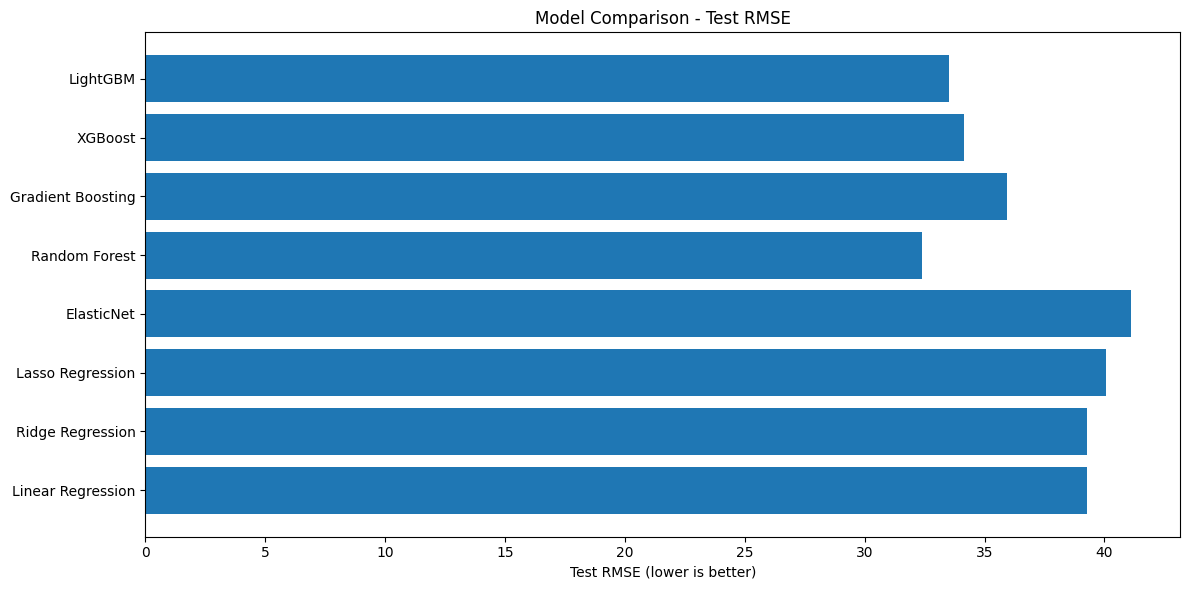

In [87]:
# Identify the best performing models
print("\nComparing model performances...")
test_rmse_scores = {name: results[name]['test_rmse'] for name in results}
best_model_name = min(test_rmse_scores, key=test_rmse_scores.get)
print(f"Best performing model based on test RMSE: {best_model_name}")

# Visualize model comparison
plt.figure(figsize=(12, 6))
plt.barh(list(test_rmse_scores.keys()), list(test_rmse_scores.values()))
plt.xlabel('Test RMSE (lower is better)')
plt.title('Model Comparison - Test RMSE')
plt.tight_layout()
plt.show()

In [88]:
# Hyperparameter tuning for the best models
print("\nPerforming hyperparameter tuning for the best models...")
print("\nTuning Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    cv=5,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

rf_grid.fit(X_train, y_train)
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
best_rf = rf_grid.best_estimator_
rf_results = evaluate_model(best_rf, X_train, X_test, y_train, y_test)


Performing hyperparameter tuning for the best models...

Tuning Random Forest...
Best Random Forest parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Training RMSE: 15.3075
Testing RMSE: 32.2903
Training MAE: 9.3413
Testing MAE: 21.4404
Training R²: 0.8935
Testing R²: 0.5029


In [89]:
# Gradient Boosting tuning
print("\nTuning Gradient Boosting...")
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

gb_grid = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=5,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

gb_grid.fit(X_train, y_train)
print(f"Best Gradient Boosting parameters: {gb_grid.best_params_}")
best_gb = gb_grid.best_estimator_
gb_results = evaluate_model(best_gb, X_train, X_test, y_train, y_test)


Tuning Gradient Boosting...


Best Gradient Boosting parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 7, 'learning_rate': 0.05}
Training RMSE: 26.8274
Testing RMSE: 33.4240
Training MAE: 18.1781
Testing MAE: 22.6536
Training R²: 0.6730
Testing R²: 0.4674


In [90]:
# XGBoost tuning
print("\nTuning XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

xgb_grid = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42),
    xgb_param_grid,
    cv=5,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

xgb_grid.fit(X_train, y_train)
print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
best_xgb = xgb_grid.best_estimator_
xgb_results = evaluate_model(best_xgb, X_train, X_test, y_train, y_test)


Tuning XGBoost...
Best XGBoost parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Training RMSE: 11.6991
Testing RMSE: 32.9738
Training MAE: 8.0446
Testing MAE: 22.0395
Training R²: 0.9378
Testing R²: 0.4816



Best tuned model based on test RMSE: Random Forest (Tuned)


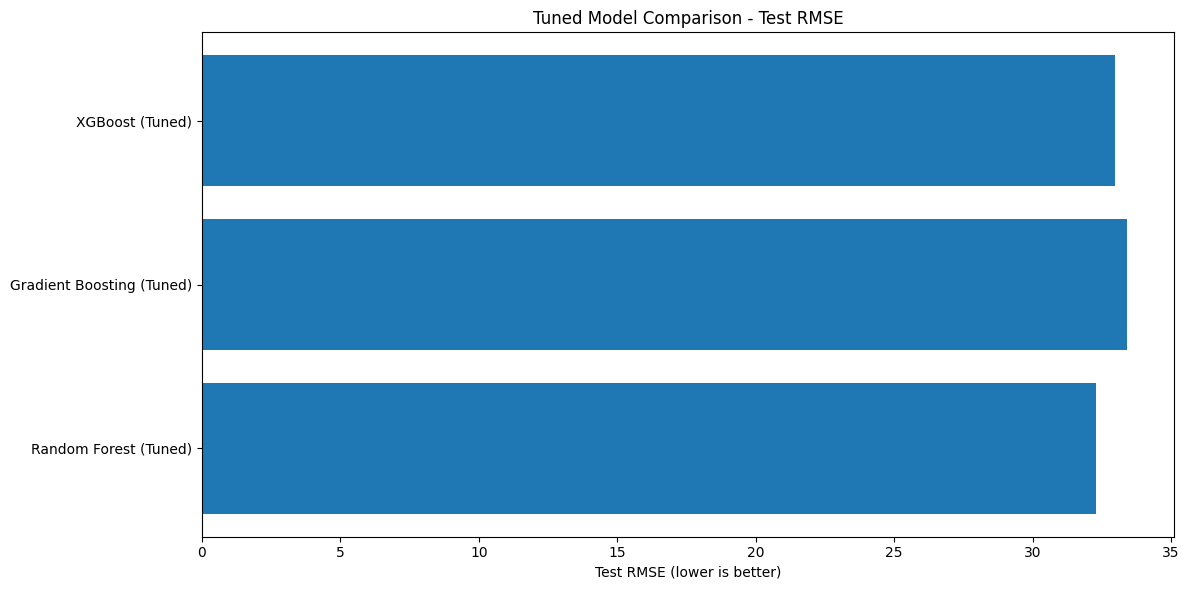

In [91]:
# Compare tuned models
tuned_results = {
    'Random Forest (Tuned)': rf_results,
    'Gradient Boosting (Tuned)': gb_results,
    'XGBoost (Tuned)': xgb_results
}

tuned_test_rmse = {name: results['test_rmse'] for name, results in tuned_results.items()}
best_tuned_model_name = min(tuned_test_rmse, key=tuned_test_rmse.get)
print(f"\nBest tuned model based on test RMSE: {best_tuned_model_name}")

# Visualize tuned model comparison
plt.figure(figsize=(12, 6))
plt.barh(list(tuned_test_rmse.keys()), list(tuned_test_rmse.values()))
plt.xlabel('Test RMSE (lower is better)')
plt.title('Tuned Model Comparison - Test RMSE')
plt.tight_layout()
plt.show()

In [92]:
# Select the best overall model
if best_tuned_model_name == 'Random Forest (Tuned)':
    best_model = best_rf
    model_name = 'random_forest'
elif best_tuned_model_name == 'Gradient Boosting (Tuned)':
    best_model = best_gb
    model_name = 'gradient_boosting'
else:
    best_model = best_xgb
    model_name = 'xgboost'

In [93]:
# Feature importance analysis
print("\nAnalyzing feature importance...")
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Feature Importances - {best_tuned_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))


Analyzing feature importance...

Top 10 most important features:
                 Feature  Importance
27                  hour    0.179447
34              hour_sin    0.046683
5      zone3_temperature    0.036488
15     zone8_temperature    0.033126
6         zone3_humidity    0.031109
0        lighting_energy    0.029160
20  atmospheric_pressure    0.025867
35              hour_cos    0.025324
1      zone1_temperature    0.021134
10        zone5_humidity    0.020384


In [94]:
# Save the best model
print(f"\nSaving the best model: {best_tuned_model_name}...")
joblib.dump(best_model, f'best_model_{model_name}.pkl')

print("\nModel development and training completed.")


Saving the best model: Random Forest (Tuned)...

Model development and training completed.


In [95]:
import os
print("Loading test data and best model...")
# Load the test data
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
feature_names = pd.read_csv('feature_names.csv').iloc[:, 0].tolist()
X_test = pd.DataFrame(X_test, columns=feature_names)
model_files = [f for f in os.listdir() if f.startswith('best_model_') and f.endswith('.pkl')]
if not model_files:
    raise FileNotFoundError("No best model file found. Please run the model development script first.")

best_model_file = model_files[0]
best_model = joblib.load(best_model_file)
print(f"Loaded model: {best_model_file}")

Loading test data and best model...
Loaded model: best_model_random_forest.pkl


In [96]:
# Make predictions on the test set
print("\nMaking predictions on the test set...")
y_pred = best_model.predict(X_test)
print("\nCalculating evaluation metrics...")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Making predictions on the test set...

Calculating evaluation metrics...
Root Mean Squared Error (RMSE): 32.2903
Mean Absolute Error (MAE): 21.4404
R² Score: 0.5029


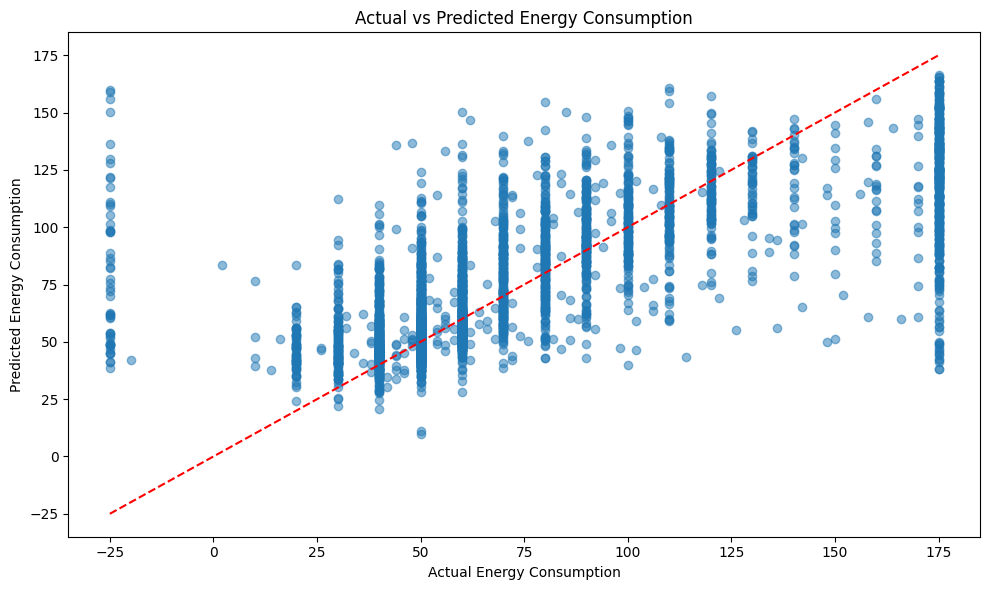

In [97]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption')
plt.tight_layout()
plt.show()

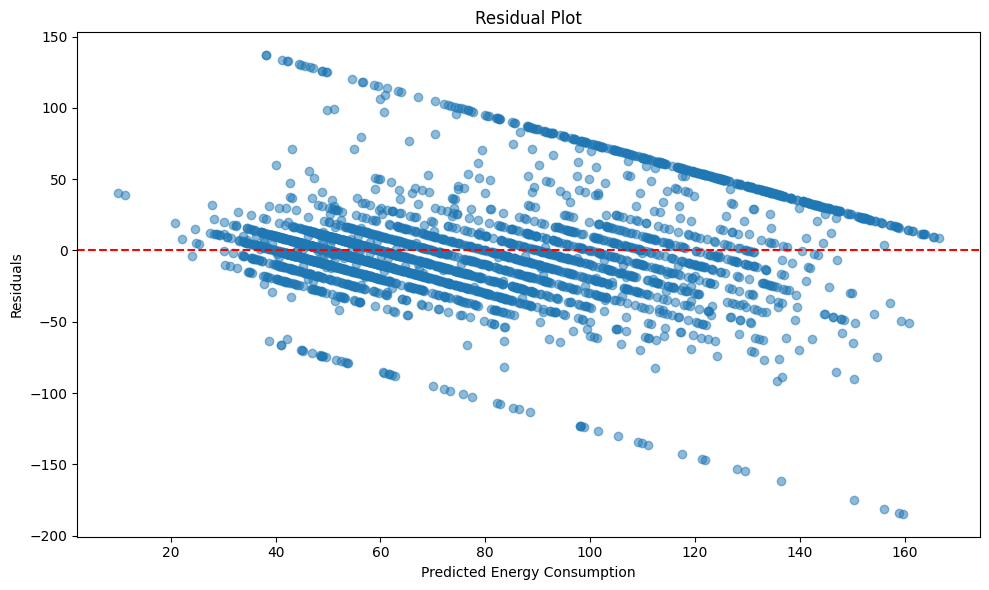

In [98]:
# Analyze residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Energy Consumption')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

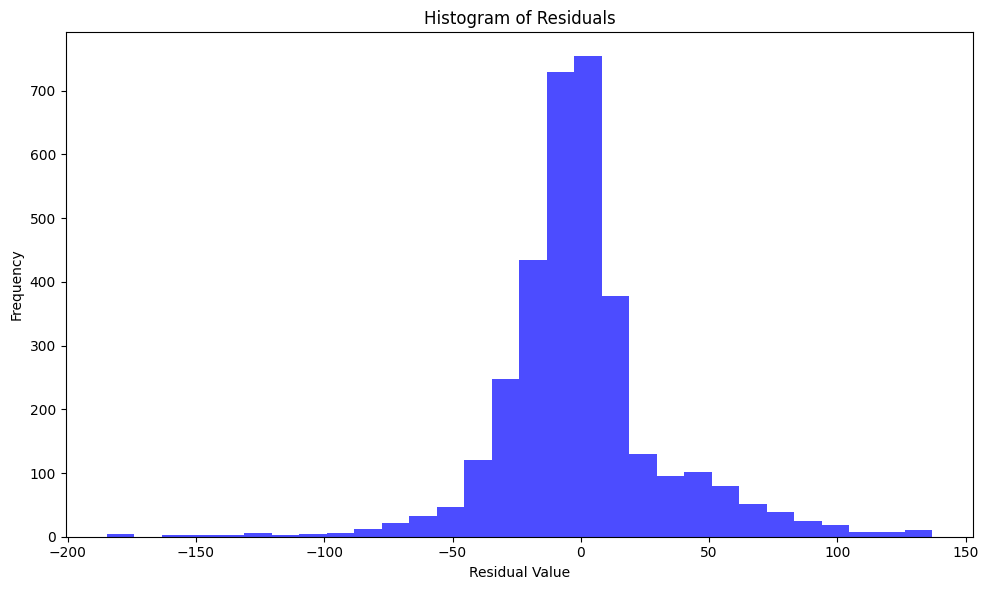

In [99]:
# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()


Analyzing feature importance...

Top 10 most important features:
                 Feature  Importance
27                  hour    0.179447
34              hour_sin    0.046683
5      zone3_temperature    0.036488
15     zone8_temperature    0.033126
6         zone3_humidity    0.031109
0        lighting_energy    0.029160
20  atmospheric_pressure    0.025867
35              hour_cos    0.025324
1      zone1_temperature    0.021134
10        zone5_humidity    0.020384


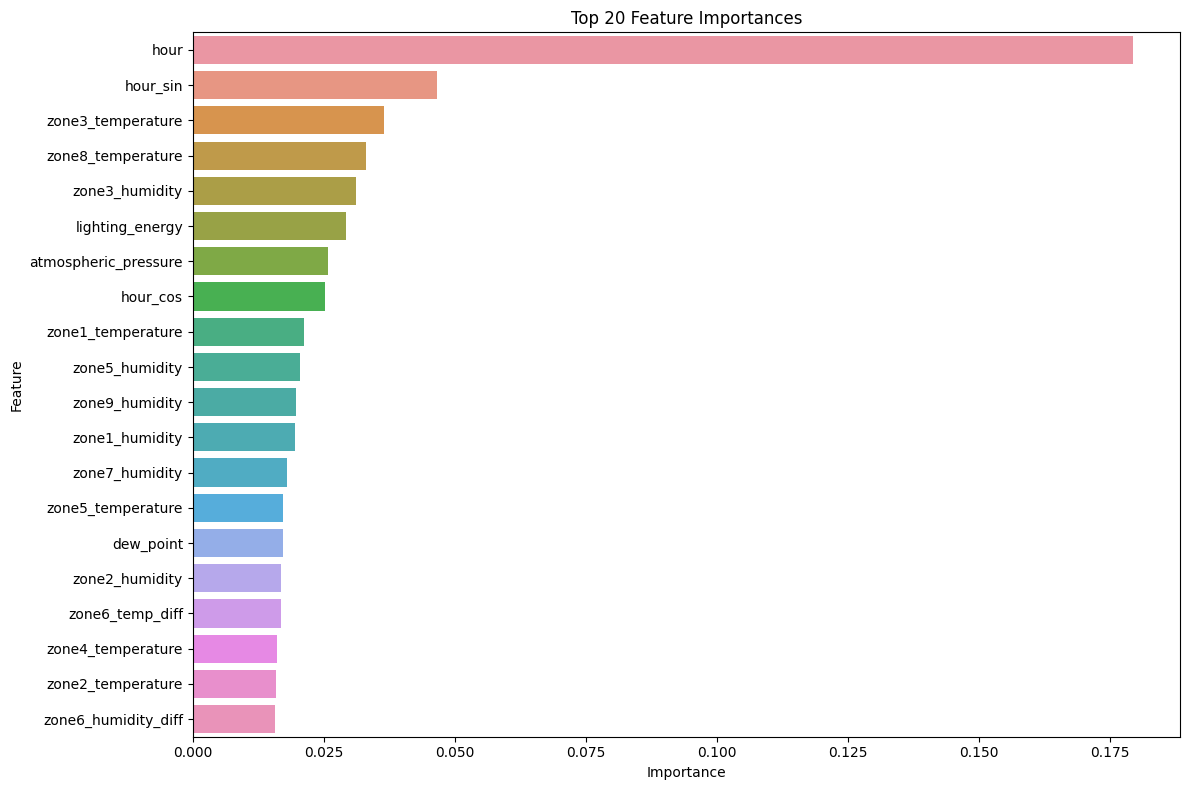


Importance of random variables:
             Feature  Importance
25  random_variable1    0.012832
26  random_variable2    0.012345
random_variable1 is ranked 25 out of 66 features (top 37.9%)
Recommendation: Keep random_variable1 in the model
random_variable2 is ranked 26 out of 66 features (top 39.4%)
Recommendation: Keep random_variable2 in the model


In [100]:
# Feature importance analysis (if available)
if hasattr(best_model, 'feature_importances_'):
    print("\nAnalyzing feature importance...")
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Print top features
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()
    
    # Analyze if random variables are important
    random_vars_importance = feature_importance[feature_importance['Feature'].str.contains('random_variable')]
    print("\nImportance of random variables:")
    print(random_vars_importance)
    
    # Determine if random variables should be included
    random_vars_rank = random_vars_importance['Feature'].apply(
        lambda x: feature_importance[feature_importance['Feature'] == x].index[0]
    )
    total_features = len(feature_importance)
    
    for var, rank in zip(random_vars_importance['Feature'], random_vars_rank):
        percentile = (rank / total_features) * 100
        print(f"{var} is ranked {rank} out of {total_features} features (top {percentile:.1f}%)")
        if percentile < 50:  # If in top 50% of features
            print(f"Recommendation: Keep {var} in the model")
        else:
            print(f"Recommendation: Consider removing {var} from the model")

In [101]:
# Generate insights and recommendations
print("\n--- Key Insights and Recommendations ---")

# Insight 1: Most important factors affecting energy consumption
if hasattr(best_model, 'feature_importances_'):
    print("\n1. Most Important Factors Affecting Energy Consumption:")
    for feature, importance in zip(feature_importance['Feature'].head(5), 
                                  feature_importance['Importance'].head(5)):
        print(f"   - {feature}: {importance:.4f}")

# Insight 2: Time-based patterns
print("\n2. Time-Based Energy Consumption Patterns:")
time_features = [f for f in feature_names if any(x in f for x in ['hour', 'day', 'month', 'weekend'])]
if time_features and hasattr(best_model, 'feature_importances_'):
    time_importance = feature_importance[feature_importance['Feature'].isin(time_features)]
    if not time_importance.empty:
        top_time_feature = time_importance.iloc[0]['Feature']
        print(f"   - Most important time factor: {top_time_feature}")
        print("   - Consider scheduling energy-intensive operations during low-consumption periods")

# Insight 3: Environmental factors
print("\n3. Environmental Factors Impact:")
env_features = [f for f in feature_names if any(x in f for x in ['temperature', 'humidity', 'pressure'])]
if env_features and hasattr(best_model, 'feature_importances_'):
    env_importance = feature_importance[feature_importance['Feature'].isin(env_features)]
    if not env_importance.empty:
        top_env_feature = env_importance.iloc[0]['Feature']
        print(f"   - Most important environmental factor: {top_env_feature}")
        print("   - Optimize HVAC systems to maintain optimal conditions for energy efficiency")

# Insight 4: Zone-specific recommendations
print("\n4. Zone-Specific Recommendations:")
zone_features = [f for f in feature_names if 'zone' in f]
if zone_features and hasattr(best_model, 'feature_importances_'):
    zone_importance = feature_importance[feature_importance['Feature'].isin(zone_features)]
    if not zone_importance.empty:
        top_zone_feature = zone_importance.iloc[0]['Feature']
        print(f"   - Most important zone factor: {top_zone_feature}")
        print("   - Focus energy efficiency efforts on the most influential zones")

# Insight 5: Model performance and limitations
print("\n5. Model Performance and Limitations:")
print(f"   - Model accuracy (R²): {r2:.4f}")
print(f"   - Average prediction error (MAE): {mae:.4f} Wh")
print("   - Regular model retraining recommended to adapt to seasonal changes")


--- Key Insights and Recommendations ---

1. Most Important Factors Affecting Energy Consumption:
   - hour: 0.1794
   - hour_sin: 0.0467
   - zone3_temperature: 0.0365
   - zone8_temperature: 0.0331
   - zone3_humidity: 0.0311

2. Time-Based Energy Consumption Patterns:
   - Most important time factor: hour
   - Consider scheduling energy-intensive operations during low-consumption periods

3. Environmental Factors Impact:
   - Most important environmental factor: zone3_temperature
   - Optimize HVAC systems to maintain optimal conditions for energy efficiency

4. Zone-Specific Recommendations:
   - Most important zone factor: zone3_temperature
   - Focus energy efficiency efforts on the most influential zones

5. Model Performance and Limitations:
   - Model accuracy (R²): 0.5029
   - Average prediction error (MAE): 21.4404 Wh
   - Regular model retraining recommended to adapt to seasonal changes


In [102]:
# Save insights to a file
with open('insights_and_recommendations.txt', 'w') as f:
    f.write("# Smart Factory Energy Prediction - Insights and Recommendations\n\n")
    
    f.write("## Model Performance\n")
    f.write(f"- Root Mean Squared Error (RMSE): {rmse:.4f}\n")
    f.write(f"- Mean Absolute Error (MAE): {mae:.4f}\n")
    f.write(f"- R² Score: {r2:.4f}\n\n")
    
    f.write("## Key Insights\n\n")
    
    if hasattr(best_model, 'feature_importances_'):
        f.write("### 1. Most Important Factors Affecting Energy Consumption:\n")
        for feature, importance in zip(feature_importance['Feature'].head(5), 
                                      feature_importance['Importance'].head(5)):
            f.write(f"- {feature}: {importance:.4f}\n")
        f.write("\n")
    
    f.write("### 2. Time-Based Energy Consumption Patterns:\n")
    if time_features and hasattr(best_model, 'feature_importances_'):
        time_importance = feature_importance[feature_importance['Feature'].isin(time_features)]
        if not time_importance.empty:
            top_time_feature = time_importance.iloc[0]['Feature']
            f.write(f"- Most important time factor: {top_time_feature}\n")
    f.write("- Consider scheduling energy-intensive operations during low-consumption periods\n\n")
    
    f.write("### 3. Environmental Factors Impact:\n")
    if env_features and hasattr(best_model, 'feature_importances_'):
        env_importance = feature_importance[feature_importance['Feature'].isin(env_features)]
        if not env_importance.empty:
            top_env_feature = env_importance.iloc[0]['Feature']
            f.write(f"- Most important environmental factor: {top_env_feature}\n")
    f.write("- Optimize HVAC systems to maintain optimal conditions for energy efficiency\n\n")
    
    f.write("### 4. Zone-Specific Recommendations:\n")
    if zone_features and hasattr(best_model, 'feature_importances_'):
        zone_importance = feature_importance[feature_importance['Feature'].isin(zone_features)]
        if not zone_importance.empty:
            top_zone_feature = zone_importance.iloc[0]['Feature']
            f.write(f"- Most important zone factor: {top_zone_feature}\n")
    f.write("- Focus energy efficiency efforts on the most influential zones\n\n")
    
    f.write("## Recommendations for Energy Reduction\n\n")
    f.write("1. **Optimize Operating Hours**: Schedule energy-intensive operations during periods of lower energy costs or demand.\n\n")
    f.write("2. **Zone-Based Temperature Control**: Implement more granular temperature control in critical zones identified by the model.\n\n")
    f.write("3. **Predictive Maintenance**: Use the model to detect abnormal energy consumption patterns that might indicate equipment issues.\n\n")
    f.write("4. **HVAC Optimization**: Adjust HVAC settings based on the identified relationship between temperature, humidity, and energy consumption.\n\n")
    f.write("5. **Continuous Monitoring**: Implement a real-time monitoring system using this predictive model to track energy usage and identify savings opportunities.\n\n")
    
    f.write("## Model Limitations and Future Improvements\n\n")
    f.write("1. **Seasonal Variations**: The model may need retraining to account for seasonal changes not captured in the current dataset.\n\n")
    f.write("2. **Additional Features**: Consider incorporating production volume data, equipment maintenance schedules, and other operational metrics to improve predictions.\n\n")
    f.write("3. **Ensemble Approach**: For production deployment, consider an ensemble of models to improve robustness and accuracy.\n\n")

print("\nEvaluation completed. Results and visualizations saved.")


Evaluation completed. Results and visualizations saved.
